# Logs Analisis

In [114]:
import re
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [115]:
logs_file = Path('/mnt/d/Documentos/Trabajo/Kosmos/OCR-General/OCR-GPU-Services/notebooks/out.log')
logs_text = logs_file.read_text()

In [116]:
# Use regex to find relevant data
# Extract something like this: Request to /tools/qr took 7.0840 seconds
pattern = r'Request to (\/[^ ]+) took (\d+\.\d+) seconds'
matches = re.findall(pattern, logs_text)
print("Found", len(matches), "matches")

# Create a DataFrame
data = {
    'endpoint': [match[0] for match in matches],
    'duration': [float(match[1]) for match in matches]
}
df = pd.DataFrame(data)

# Split each endpoint into groups of 20 requests
df['batch'] = df.groupby('endpoint').cumcount() // 20 + 1
# Map batch numbers to concurrency levels: batch 1 -> 1, batch 2 -> 4, batch 3 -> 8
batch_mapping = {1: 1, 2: 4, 3: 8}
df['batch'] = df['batch'].map(batch_mapping)
df['group_name'] = df['endpoint'] + '_group_' + df['batch'].astype(str)

# Display the DataFrame with groups
df.head()

Found 299 matches


,endpoint,duration,batch,group_name
0,/tools/signature,4.1712,1,/tools/signature_group_1
1,/tools/signature,1.2664,1,/tools/signature_group_1
2,/tools/signature,0.3231,1,/tools/signature_group_1
3,/tools/signature,0.5879,1,/tools/signature_group_1
4,/tools/signature,0.3204,1,/tools/signature_group_1


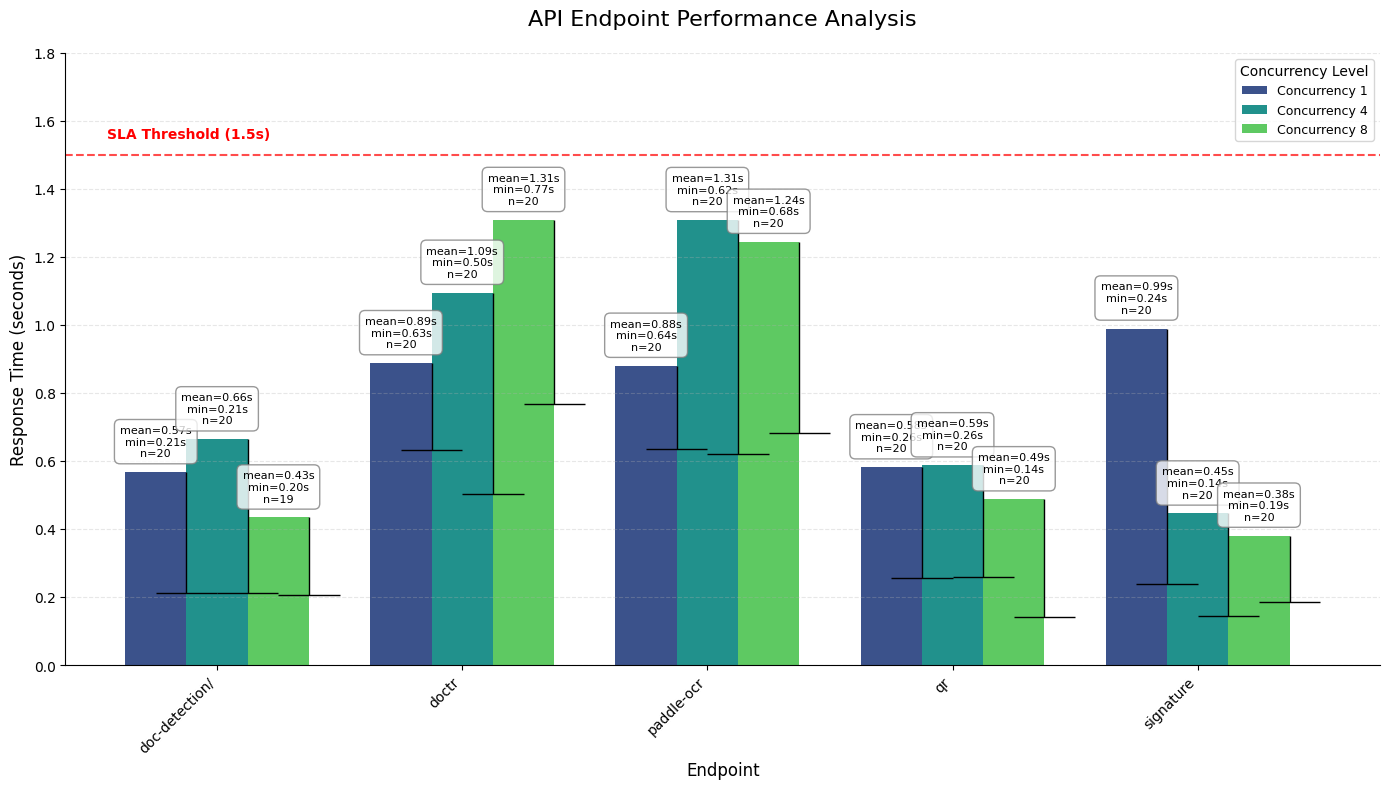

In [117]:
# Plot the results by endpoint with separate bars for each concurrency level
plt.figure(figsize=(14, 8))

# Calculate statistics for each group
group_stats = df.groupby(['endpoint', 'batch'])['duration'].agg(['mean', 'min', 'count']).reset_index()

# Sort by endpoint for better visualization
group_stats = group_stats.sort_values(['endpoint', 'batch'])

# Get unique endpoints for x-axis
endpoints = sorted(df['endpoint'].unique())

# Create a categorical color palette based on batch numbers
batch_numbers = sorted(df['batch'].unique())
batch_colors = dict(zip(batch_numbers, sns.color_palette('viridis', len(batch_numbers))))

# Set up the positions for grouped bars
x = np.arange(len(endpoints))
width = 0.25  # Width of each bar
multiplier = 0

# Create grouped bar chart
ax = plt.subplot()
for batch in batch_numbers:
    # Filter data for this batch
    batch_data = group_stats[group_stats['batch'] == batch]
    
    # Create dictionaries mapping endpoint to stats for this batch
    endpoint_means = {row['endpoint']: row['mean'] for _, row in batch_data.iterrows()}
    endpoint_mins = {row['endpoint']: row['min'] for _, row in batch_data.iterrows()}
    endpoint_counts = {row['endpoint']: row['count'] for _, row in batch_data.iterrows()}
    
    # Get stats for all endpoints (use 0 if endpoint not in this batch)
    means = [endpoint_means.get(endpoint, 0) for endpoint in endpoints]
    mins = [endpoint_mins.get(endpoint, 0) for endpoint in endpoints]
    counts = [endpoint_counts.get(endpoint, 0) for endpoint in endpoints]
    
    # Plot bars for this batch
    offset = width * multiplier
    
    rects = ax.bar(x + offset, means, width, label=f'Concurrency {batch}', color=batch_colors[batch])
    
    # Add error bars for min
    ax.vlines(x + offset + width/2, mins, means, color='black', linestyle='-', lw=1)
    ax.hlines(mins, x + offset, x + offset + width, color='black', linestyle='-', lw=1)
    
    # Add annotations with improved positioning and formatting
    for i, rect in enumerate(rects):
        if means[i] > 0:  # Only annotate bars with data
            height = rect.get_height()
            ax.annotate(f'mean={means[i]:.2f}s\nmin={mins[i]:.2f}s\nn={counts[i]}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 10),  # 10 points vertical offset
                       textcoords='offset points',
                       ha='center', va='bottom',
                       fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8))
    
    multiplier += 1

# Customize plot appearance
ax.set_title('API Endpoint Performance Analysis', fontsize=16, pad=20)
ax.set_xlabel('Endpoint', fontsize=12)
ax.set_ylabel('Response Time (seconds)', fontsize=12)

# Improve x-axis labels
ax.set_xticks(x + width)
ax.set_xticklabels([endpoint.replace('/tools/', '').replace('/detect/', '') for endpoint in endpoints], 
                   rotation=45, ha='right')

# Customize grid and spines
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add threshold line with improved styling
threshold = 1.5
plt.axhline(y=threshold, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.text(-0.2, threshold + 0.05, 'SLA Threshold (1.5s)', 
         color='red', fontsize=10, fontweight='bold')

# Improve legend
ax.legend(title="Concurrency Level", 
         title_fontsize=10,
         fontsize=9,
         loc='upper right',
         bbox_to_anchor=(1, 1),
         frameon=True)

# Set y-axis limits with some padding
plt.ylim(0, max(group_stats['mean'].max() * 1.1, threshold * 1.2))

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()